<a href="https://colab.research.google.com/github/PratikNagdeve/genai-lab-assignments/blob/main/GenAI__3_January_2025_3_03PM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lab Problem Statement: Human Activity Recognition (HAR) using WISDM.

Problem Definition:

Develop a Deep Learning model to classify human physical activities based on tri-axial accelerometer data.
You are provided with the WISDM (Wireless Sensor Data Mining) dataset, which contains accelerometer recordings from 36 users performing 6 distinct activities.

Objective:

Preprocess the raw time-series data using a Sliding Window technique (segmentation).
Build a 1D Convolutional Neural Network (CNN) or LSTM model to classify the activities.
Evaluate the model's accuracy and visualize the Confusion Matrix.
Target Activities: Walking, Jogging, Upstairs, Downstairs, Sitting, Standing.

Colab Implementation
You can copy-paste the code below directly into a Google Colab cell. It includes a command to automatically download the dataset so you don't need to manually upload files.

In [ ]:
from google.colab import files

uploaded = files.upload()


Saving time_series_data_human_activities.csv to time_series_data_human_activities.csv


In [ ]:
import pandas as pd
data = pd.read_csv("time_series_data_human_activities.csv")
data.head()



,user,activity,timestamp,x-axis,y-axis,z-axis
0,1,Walking,4991922345000,0.69,10.80,-2.03
1,1,Walking,4991972333000,6.85,7.44,-0.50
2,1,Walking,4992022351000,0.93,5.63,-0.50
3,1,Walking,4992072339000,-2.11,5.01,-0.69
4,1,Walking,4992122358000,-4.59,4.29,-1.95


In [ ]:
data.isnull().sum()
data.dropna(inplace=True)
data = data[['x-axis', 'y-axis', 'z-axis', 'activity']]




In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data['activity_encoded'] = label_encoder.fit_transform(data['activity'])

# Check mapping
for i, label in enumerate(label_encoder.classes_):
    print(i, "->", label)



0 -> Downstairs
1 -> Jogging
2 -> Sitting
3 -> Standing
4 -> Upstairs
5 -> Walking


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data[['x-axis', 'y-axis', 'z-axis']] = scaler.fit_transform(data[['x-axis', 'y-axis', 'z-axis']])


In [ ]:
import numpy as np

def sliding_window(data, window_size=128, step_size=64):
    X, y = [], []

    for i in range(0, len(data) - window_size, step_size):
        window_data = data[['x-axis', 'y-axis', 'z-axis']].iloc[i:i+window_size].values
        label = data['activity_encoded'].iloc[i:i+window_size].mode()[0]

        X.append(window_data)
        y.append(label)

    return np.array(X), np.array(y)

X, y = sliding_window(data)

X.shape, y.shape



((16774, 128, 3), (16774,))

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

y_cat = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42
)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(128, 3)),
    MaxPooling1D(pool_size=2),

    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(6, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 126, 64)        │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 61, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3840)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       491,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 517,766 (1.98 MB)

 Trainable params: 517,766 (1.98 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.2
)


Epoch 1/5
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9265 - loss: 0.2179 - val_accuracy: 0.9270 - val_loss: 0.2103
Epoch 2/5
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9479 - loss: 0.1581 - val_accuracy: 0.9504 - val_loss: 0.1463
Epoch 3/5
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.9680 - loss: 0.0991 - val_accuracy: 0.9523 - val_loss: 0.1420
Epoch 4/5
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.9762 - loss: 0.0797 - val_accuracy: 0.9601 - val_loss: 0.1127
Epoch 5/5
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9794 - loss: 0.0642 - val_accuracy: 0.9609 - val_loss: 0.1189


In [ ]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true, y_pred_classes)
print("Test Accuracy:", accuracy)


105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Test Accuracy: 0.9651266766020864


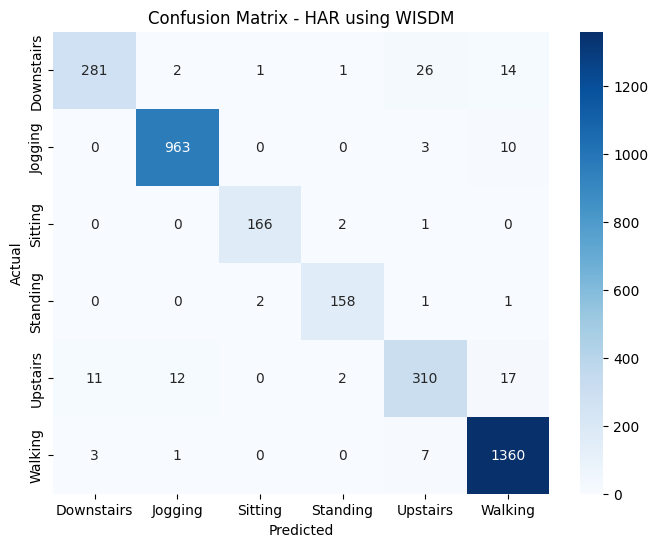

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - HAR using WISDM")
plt.show()


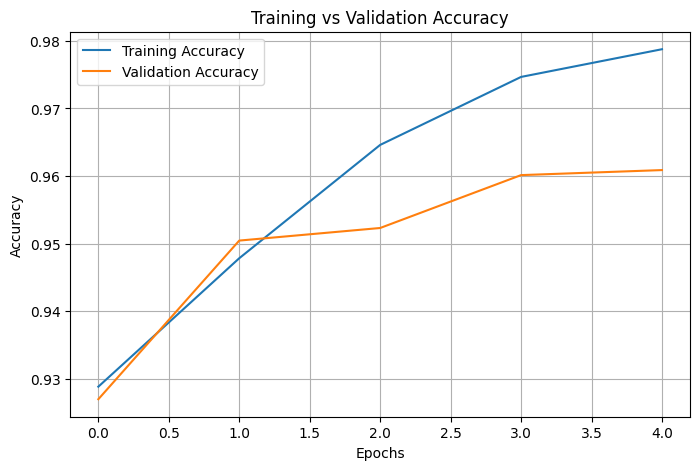

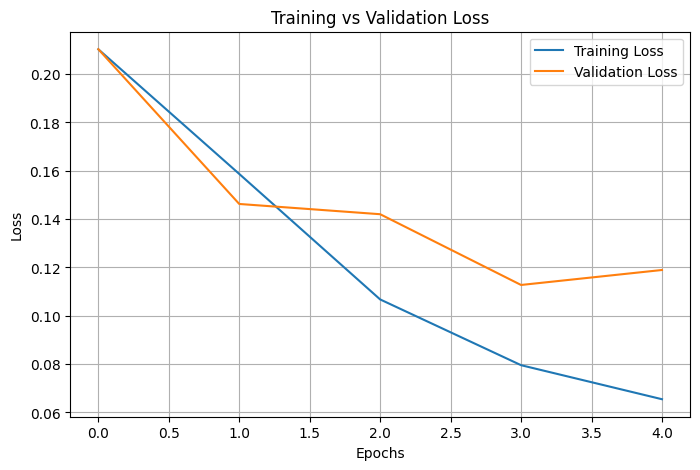

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
